# Setting

In [14]:
import pandas as pd
import FinanceDataReader as fdr

from pf_utils import convert_rate_to_price
from pf_utils import BacktestManager, get_date_range, AssetEvaluator

In [2]:
path_data = 'data'

In [3]:
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

## testing

### class

### test

# Data

## TDF
- https://www.kiwoomam.com/fund/KI0202020000M?parentfundcode=8325&fundcode=8335
- https://investments.miraeasset.com/fund/view.do?fundGb=2&fundCd=537380&childFundGb=2&childFundCd=53738P
- https://www.hanwhawm.com/main/finance/fundInfo/FI141_2.cmd?p=500&item_cd=5102896

In [9]:
file = '금융자산운용 - export.csv'
df_info = pd.read_csv(f'{path_data}/{file}')
df_info.head()

,name,ticker,commission,data_type,file,check1_date,check1_price,check2_date,check2_price
0,미래에셋전략배분TDF2035혼합자산자투자신탁종류C-P2e,K55301BU6139,0.60,2,K55301BU6139,2024-6-10,1567.62,2021-6-10,1418.06
1,키움키워드림TDF2030증권투자신탁 1[혼합-재간접형]C-P2e(퇴직연금),K55206C95800,0.48,1,K55206C95800,2024-6-10,1350.64,2021-6-10,1301.55
2,미래에셋평생소득TIF혼합자산자투자신탁종류C-P2e,K55301BU5453,0.54,2,K55301BU5453,2024-6-10,1263.17,2021-6-10,1230.86
3,미래에셋전략배분TDF2045혼합자산자투자신탁 종류C-P2e,K55301BU5479,0.74,2,K55301BU5479,2024-6-10,1686.84,2021-6-10,1519.23
4,키움키워드림TDF2045증권투자신탁 1[혼합-재간접형]C-P2e(퇴직연금),K55206C96311,0.68,1,K55206C96311,2024-6-10,1400.90,2021-6-10,1322.36


In [7]:
tdf_names = df_info.set_index('ticker')['name'].to_dict()
commissions = df_info.set_index('ticker')['commission'].to_dict()
{tdf_names[k]:v for k,v in commissions.items()}

{'미래에셋전략배분TDF2035혼합자산자투자신탁종류C-P2e': 0.6,
 '키움키워드림TDF2030증권투자신탁 1[혼합-재간접형]C-P2e(퇴직연금)': 0.48,
 '미래에셋평생소득TIF혼합자산자투자신탁종류C-P2e': 0.54,
 '미래에셋전략배분TDF2045혼합자산자투자신탁 종류C-P2e': 0.74,
 '키움키워드림TDF2045증권투자신탁 1[혼합-재간접형]C-P2e(퇴직연금)': 0.68,
 'KODEX 미국S&P500TR assumed from S&P500 rate of return': 0.0}

In [8]:
df_info = df_info.iloc[:-1]
df_tdfs = None

for _, data in df_info.iterrows():
    df = convert_rate_to_price(data, path=path_data)
    
    if df_tdfs is None:
        df_tdfs = df.to_frame()
    else:
        df_tdfs = df_tdfs.join(df, how='outer')

error: -0.07 %
error: -0.00 %
error: 0.16 %
error: -0.13 %
error: 0.00 %


In [10]:
get_date_range(df_tdfs)

,start date,end date
K55301BU5479,2017-08-14,2024-06-16
K55301BU6139,2017-09-20,2024-06-16
K55301BU5453,2017-09-29,2024-06-16
K55206C96311,2018-07-13,2024-06-17
K55206C95800,2018-07-26,2024-06-13


<Axes: xlabel='date'>

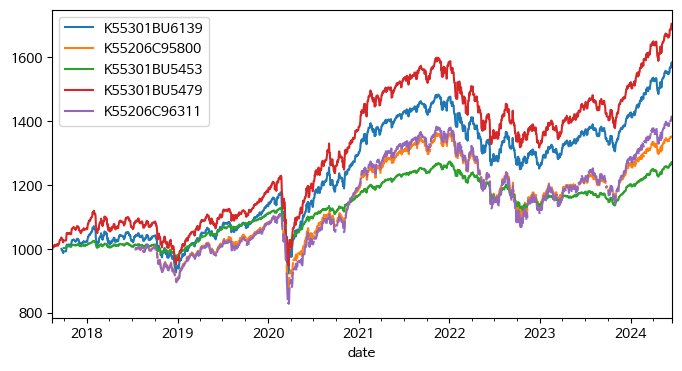

In [11]:
df_tdfs.plot(figsize=(8,4))

## ETF

In [12]:
file = 'etfs_selected_240611.csv'
df_etfs = pd.read_csv(f'{path_data}/{file}', parse_dates=[0], index_col=0)
df_etfs.head()

,273130,453850,284430,069500,379800,411060,305080,304660,148070,261220
Date,,,,,,,,,,
2002-10-14,NaN,NaN,NaN,5184,NaN,NaN,NaN,NaN,NaN,NaN
2002-10-15,NaN,NaN,NaN,5312,NaN,NaN,NaN,NaN,NaN,NaN
2002-10-16,NaN,NaN,NaN,5335,NaN,NaN,NaN,NaN,NaN,NaN
2002-10-17,NaN,NaN,NaN,5410,NaN,NaN,NaN,NaN,NaN,NaN
2002-10-18,NaN,NaN,NaN,5642,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
df_sym = fdr.StockListing('ETF/KR') # 한국 ETF 전종목

symbols = df_etfs.columns
etf_names = df_sym.loc[df_sym.Symbol.isin(symbols)].set_index('Symbol')['Name'].to_dict()
etf_names

{'069500': 'KODEX 200',
 '273130': 'KODEX 종합채권(AA-이상)액티브',
 '379800': 'KODEX 미국S&P500TR',
 '453850': 'ACE 미국30년국채액티브(H)',
 '148070': 'KOSEF 국고채10년',
 '304660': 'KODEX 미국30년국채울트라선물(H)',
 '411060': 'ACE KRX금현물',
 '305080': 'TIGER 미국채10년선물',
 '284430': 'KODEX 200미국채혼합',
 '261220': 'KODEX WTI원유선물(H)'}

In [16]:
get_date_range(df_etfs)

,start date,end date
069500,2002-10-14,2024-06-11
148070,2011-10-20,2024-06-11
261220,2016-12-27,2024-06-11
273130,2017-06-29,2024-06-11
284430,2017-11-30,2024-06-11
305080,2018-08-30,2024-06-11
304660,2018-09-12,2024-06-11
379800,2021-04-09,2024-06-11
411060,2021-12-15,2024-06-11
453850,2023-03-14,2024-06-11


In [17]:
asset_names = etf_names.copy()
asset_names.update(tdf_names)

# Backtest

## TDF

In [20]:
kwargs_bm = dict(
    initial_capital = 10000000,
    commissions = 0,
    align_axis=0, 
    days_in_year=365,
    asset_names = asset_names
)

### compare 1

In [21]:
bm = BacktestManager(df_tdfs, **kwargs_bm)

period reset: 2018-07-26 ~ 2024-06-13
running self.util_check_days_in_year to check days in a year


In [22]:
name = 'KOSPI'
ticker = '069500'
df_kospi = bm.util_import_data(ticker, name=name)

In [23]:
kwargs = dict(
    freq = 'Y', select = 'all', weigh = 'specified'
)

kwa_list = list()
for c in bm.df_assets.columns:
    kwa = {'name':c, 'weights':c}
    kwa_list.append(kwa)

bm.build_batch(*kwa_list, reset_portfolios=False, **kwargs)

In [24]:
bm.build(
    name = 'COMB1: Eqaully',
    freq = 'Y', select = 'all', weigh = 'equally'
)

In [25]:
bm.build(
    name = 'COMB2: ERC',
    freq = 'Y', select = 'all', weigh = 'ERC', 
    lookback=12, lag=0
)

In [26]:
bm.build(    
    name = 'COMB3: InvVol',
    freq = 'Y', select = 'all', weigh = 'InvVol', 
    lookback=12, lag=0
)

In [27]:
bm.benchmark(df_kospi)

RunOnce selected


Backtesting 9 strategies: K55301BU6139, K55206C95800, ... , KOSPI


100%|█████████████████████████████████████████████████████████████████| 9/9 [00:03<00:00,  2.40it/s]


Returning stats


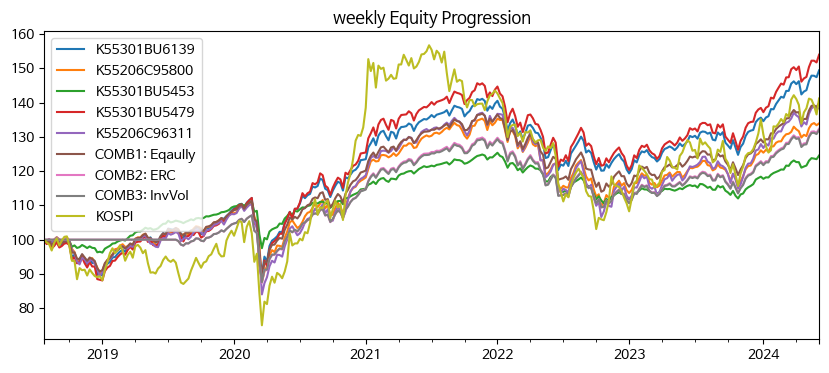

In [28]:
_ = bm.run(figsize=(10,4), freq='W')

In [29]:
bm.get_stats(sort_by='monthly_sharpe')

,K55301BU6139,K55301BU5479,K55301BU5453,COMB1: Eqaully,COMB3: InvVol,COMB2: ERC,K55206C95800,K55206C96311,KOSPI
start,2018-07-25 00:00:00,2018-07-25 00:00:00,2018-07-25 00:00:00,2018-07-25 00:00:00,2018-07-25 00:00:00,2018-07-25 00:00:00,2018-07-25 00:00:00,2018-07-25 00:00:00,2018-07-25 00:00:00
end,2024-06-13 00:00:00,2024-06-13 00:00:00,2024-06-13 00:00:00,2024-06-13 00:00:00,2024-06-13 00:00:00,2024-06-13 00:00:00,2024-06-13 00:00:00,2024-06-13 00:00:00,2024-06-13 00:00:00
total_return,0.504679,0.551419,0.250209,0.409573,0.328673,0.33254,0.349493,0.399272,0.427652
cagr,0.071877,0.077461,0.038666,0.060053,0.049462,0.04998,0.052238,0.058733,0.06235
calmar,0.334189,0.338044,0.299002,0.289013,0.2582,0.258253,0.237476,0.232444,0.180217
max_drawdown,-0.215078,-0.229146,-0.129315,-0.207786,-0.191565,-0.193532,-0.219971,-0.252675,-0.345974
avg_drawdown,-0.013912,-0.016287,-0.006914,-0.014604,-0.012442,-0.012857,-0.017237,-0.01988,-0.052904
avg_drawdown_days,26.802817,28.161765,26.257143,32.298246,29.88,30.693878,34.672727,37.607843,82.28
daily_vol,0.093971,0.105574,0.045479,0.067398,0.058253,0.058888,0.090317,0.107869,0.192791
daily_sharpe,0.803918,0.77701,0.877389,0.920299,0.878273,0.878024,0.622823,0.596079,0.417635


#### cross-validation

In [210]:
bm.cv_strategies

0) K55301BU6139: 미래에셋전략배분TDF2035혼합자산자투자신탁종류C-P2e
1) K55206C95800: 키움키워드림TDF2030증권투자신탁 1[혼합-재간접형]C-P2e(퇴직연금)
2) K55301BU5453: 미래에셋평생소득TIF혼합자산자투자신탁종류C-P2e
3) K55301BU5479: 미래에셋전략배분TDF2045혼합자산자투자신탁 종류C-P2e
4) K55206C96311: 키움키워드림TDF2045증권투자신탁 1[혼합-재간접형]C-P2e(퇴직연금)
5) COMB1: Eqaully
6) COMB2: ERC
7) COMB3: InvVol

In [211]:
pf_list = [0,5,6,7]
bm.cross_validate(pf_list, n_sample=10)

Cross-validating 4 strategies: K55301BU6139, COMB1: Eqaully, COMB2: ERC, COMB3: InvVol


100%|███████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.13it/s]


,K55301BU6139,COMB1: Eqaully,COMB2: ERC,COMB3: InvVol
avg_drawdown,-0.01 ± 0.001,-0.01 ± 0.001,-0.01 ± 0.001,-0.01 ± 0.001
avg_drawdown_days,21.95 ± 1.427,22.89 ± 1.241,25.75 ± 2.814,22.84 ± 1.405
cagr,0.08 ± 0.007,0.07 ± 0.006,0.05 ± 0.006,0.06 ± 0.005
calmar,0.37 ± 0.032,0.32 ± 0.029,0.25 ± 0.032,0.32 ± 0.028
daily_sharpe,0.74 ± 0.057,0.84 ± 0.071,0.69 ± 0.078,0.86 ± 0.067
daily_sortino,1.07 ± 0.085,1.22 ± 0.106,0.99 ± 0.116,1.23 ± 0.100
daily_vol,0.08 ± 0.001,0.05 ± 0.001,0.05 ± 0.001,0.05 ± 0.001
max_drawdown,-0.22 ± 0.000,-0.21 ± 0.000,-0.19 ± 0.000,-0.19 ± 0.000
monthly_sharpe,0.84 ± 0.064,0.70 ± 0.056,0.58 ± 0.063,0.71 ± 0.054
monthly_sortino,1.35 ± 0.117,1.08 ± 0.095,0.86 ± 0.100,1.07 ± 0.090


### compare 2

In [296]:
choice = ['K55301BU6139', 'K55206C95800']

bm = BacktestManager(df_tdfs[choice], **kwargs_bm)

period reset: 2018-07-26 ~ 2024-06-13


In [297]:
name = 'KOSPI'
ticker = '069500'
df_kospi = bm.util_import_data(ticker, name=name)

In [298]:
kwargs = dict(
    freq = 'Y', select = 'all', weigh = 'specified'
)

kwa_list = list()
for c in bm.df_assets.columns:
    kwa = {'name':c, 'weights':c}
    kwa_list.append(kwa)

bm.build_batch(*kwa_list, reset_portfolios=False, **kwargs)

In [299]:
bm.buy_n_hold(
    name = 'COMB: Buy&Hold'
)

RunOnce selected


In [300]:
bm.build(
    name = 'COMB: Eqaully',
    freq = 'Y', select = 'all', weigh = 'equally'
)

In [301]:
bm.build(
    name = 'COMB: InvVol',
    freq = 'Y', select = 'all', weigh = 'InvVol',
    lookback=12, lag=0
)

In [302]:
bm.benchmark(df_kospi)

RunOnce selected


Backtesting 6 strategies: K55301BU6139, K55206C95800, ... , KOSPI


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.34it/s]


Returning stats


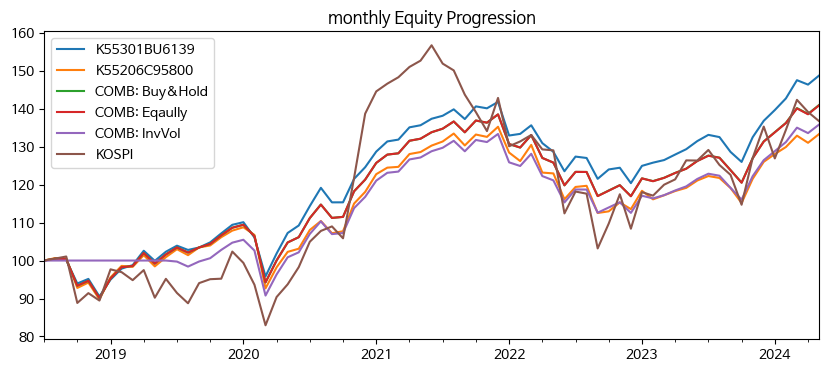

In [303]:
_ = bm.run(figsize=(10,4), freq='M')

In [304]:
bm.get_stats(sort_by='monthly_sharpe')

,K55301BU6139,COMB: Buy&Hold,COMB: Eqaully,COMB: InvVol,K55206C95800,KOSPI
start,2018-07-25 00:00:00,2018-07-25 00:00:00,2018-07-25 00:00:00,2018-07-25 00:00:00,2018-07-25 00:00:00,2018-07-25 00:00:00
end,2024-06-13 00:00:00,2024-06-13 00:00:00,2024-06-13 00:00:00,2024-06-13 00:00:00,2024-06-13 00:00:00,2024-06-13 00:00:00
total_return,0.504679,0.427069,0.42572,0.380634,0.349493,0.427652
cagr,0.071877,0.062277,0.062106,0.056324,0.052238,0.06235
calmar,0.334189,0.288806,0.288009,0.261127,0.237476,0.180217
max_drawdown,-0.215078,-0.215635,-0.215639,-0.215695,-0.219971,-0.345974
avg_drawdown,-0.013912,-0.016183,-0.016187,-0.015074,-0.017237,-0.052904
avg_drawdown_days,26.802817,34.277778,34.277778,32.085106,34.672727,82.28
daily_vol,0.093971,0.070181,0.07022,0.066594,0.090317,0.192791
daily_sharpe,0.803918,0.91714,0.914325,0.876377,0.622823,0.417635


In [305]:
bm.build(
    name = 'COMB: InvVol2',
    freq = 'Q', select = 'all', weigh = 'InvVol',
    lookback=12, lag=0
)

bm.build(
    name = 'COMB: MeanVar',
    freq = 'Q', select = 'all', weigh = 'MeanVar',
    lookback=12, lag=0
)

In [306]:
bm.portfolios

0) K55301BU6139: 미래에셋전략배분TDF2035혼합자산자투자신탁종류C-P2e
1) K55206C95800: 키움키워드림TDF2030증권투자신탁 1[혼합-재간접형]C-P2e(퇴직연금)
2) COMB: Buy&Hold
3) COMB: Eqaully
4) COMB: InvVol
5) KOSPI
6) COMB: InvVol2
7) COMB: MeanVar

In [307]:
bm.run([4,6,7], plot=False)

Backtesting 3 strategies: COMB: InvVol, COMB: InvVol2, COMB: MeanVar


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  3.00it/s]

Returning stats


,COMB: InvVol,COMB: InvVol2,COMB: MeanVar
start,2018-07-25 00:00:00,2018-07-25 00:00:00,2018-07-25 00:00:00
end,2024-06-13 00:00:00,2024-06-13 00:00:00,2024-06-13 00:00:00
total_return,0.380634,0.516172,0.446328
cagr,0.056324,0.073263,0.064699
calmar,0.261127,0.339703,0.300176
max_drawdown,-0.215695,-0.215668,-0.215536
avg_drawdown,-0.013894,-0.013843,-0.012394
avg_drawdown_days,29.843137,28.47541,25.758065
daily_vol,0.05461,0.056506,0.059273
daily_sharpe,0.719687,0.891691,0.759498


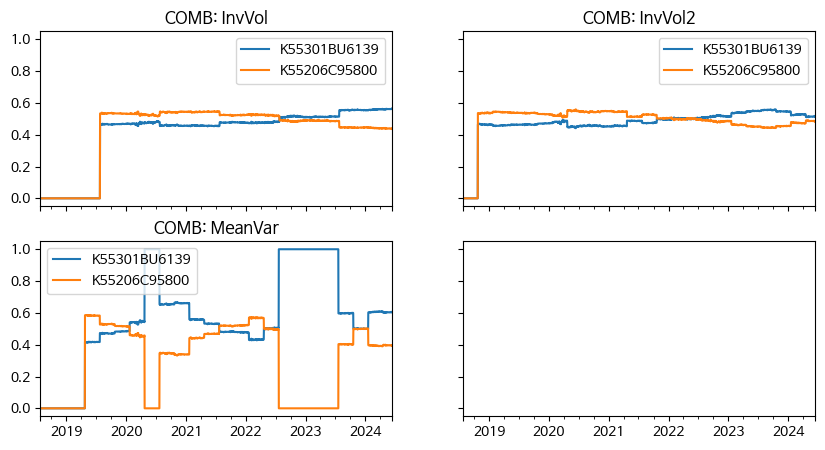

In [308]:
bm.plot_security_weights(figsize=(10,5))

In [309]:
df = bm.get_security_weights(1)
df.head()

COMB: InvVol2: weights at transactions returned


,K55301BU6139,K55206C95800
Date,,
2018-10-25,0.463921,0.535992
2019-01-24,0.455569,0.544366
2019-04-25,0.461322,0.538581
2019-07-25,0.466092,0.533813
2019-10-24,0.468700,0.531217


#### cross-validation

In [310]:
bm.cv_strategies

0) K55301BU6139: 미래에셋전략배분TDF2035혼합자산자투자신탁종류C-P2e
1) K55206C95800: 키움키워드림TDF2030증권투자신탁 1[혼합-재간접형]C-P2e(퇴직연금)
2) COMB: Buy&Hold
3) COMB: Eqaully
4) COMB: InvVol
5) COMB: InvVol2
6) COMB: MeanVar

In [311]:
pf_list = [0,3,4,6]
bm.cross_validate(pf_list)

Cross-validating 4 strategies: K55301BU6139, COMB: Eqaully, COMB: InvVol, COMB: MeanVar


100%|███████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.94it/s]


,K55301BU6139,COMB: Eqaully,COMB: InvVol,COMB: MeanVar
avg_drawdown,-0.01 ± 0.001,-0.01 ± 0.001,-0.01 ± 0.001,-0.01 ± 0.001
avg_drawdown_days,21.80 ± 1.578,27.91 ± 1.556,27.69 ± 1.887,26.76 ± 1.973
cagr,0.08 ± 0.006,0.07 ± 0.006,0.07 ± 0.006,0.06 ± 0.004
calmar,0.38 ± 0.030,0.33 ± 0.028,0.33 ± 0.029,0.29 ± 0.020
daily_sharpe,0.76 ± 0.054,0.87 ± 0.071,0.87 ± 0.071,0.73 ± 0.043
daily_sortino,1.10 ± 0.081,1.26 ± 0.107,1.27 ± 0.107,1.05 ± 0.065
daily_vol,0.08 ± 0.001,0.06 ± 0.001,0.06 ± 0.001,0.06 ± 0.001
max_drawdown,-0.22 ± 0.000,-0.22 ± 0.000,-0.22 ± 0.000,-0.22 ± 0.003
monthly_sharpe,0.85 ± 0.062,0.72 ± 0.057,0.72 ± 0.058,0.67 ± 0.037
monthly_sortino,1.38 ± 0.111,1.12 ± 0.098,1.11 ± 0.099,1.02 ± 0.071


In [312]:
bm.portfolios

0) K55301BU6139
1) K55206C95800
2) COMB: Buy&Hold
3) COMB: Eqaully
4) COMB: InvVol
5) KOSPI
6) COMB: InvVol2
7) COMB: MeanVar

In [313]:
bm.cv_strategies

0) K55301BU6139: 미래에셋전략배분TDF2035혼합자산자투자신탁종류C-P2e
1) K55206C95800: 키움키워드림TDF2030증권투자신탁 1[혼합-재간접형]C-P2e(퇴직연금)
2) COMB: Buy&Hold
3) COMB: Eqaully
4) COMB: InvVol
5) COMB: InvVol2
6) COMB: MeanVar

## ETF

In [125]:
choice = ['069500', '273130', '148070', '379800']
[asset_names[x] for x in choice]

['KODEX 200', 'KODEX 종합채권(AA-이상)액티브', 'KOSEF 국고채10년', 'KODEX 미국S&P500TR']

In [126]:
kwargs_bm = dict(
    initial_capital = 10000000,
    commissions = 0,
    align_axis=0, 
    days_in_year=246
)

### compare 1

In [127]:
bm = BacktestManager(df_etfs[choice], **kwargs_bm)

period reset: 2021-04-09 ~ 2024-06-11


In [128]:
name = 'KOSPI'
ticker = '069500'
df_kospi = bm.util_import_data(ticker, name=name)

In [129]:
kwargs = dict(
    freq = 'Y', select = 'all', weigh = 'specified'
)

kwa_list = list()
for c in bm.df_assets.columns:
    c2 = asset_names[c]
    kwa = {'name':c2, 'weights':c}
    kwa_list.append(kwa)

bm.build_batch(*kwa_list, reset_portfolios=False, **kwargs)

In [130]:
bm.build(
    name = 'COMB1: Eqaully',
    freq = 'Y', select = 'all', weigh = 'equally'
)

In [131]:
bm.build(
    name = 'COMB2: ERC',
    freq = 'Y', select = 'all', weigh = 'ERC', 
    lookback=12, lag=0
)

In [132]:
bm.build(    
    name = 'COMB3: InvVol',
    freq = 'Y', select = 'all', weigh = 'InvVol', 
    lookback=12, lag=0
)

In [133]:
bm.benchmark(df_kospi)

RunOnce selected


Backtesting 8 strategies: KODEX 200, KODEX 종합채권(AA-이상)액티브, ... , KOSPI


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.07it/s]


Returning stats


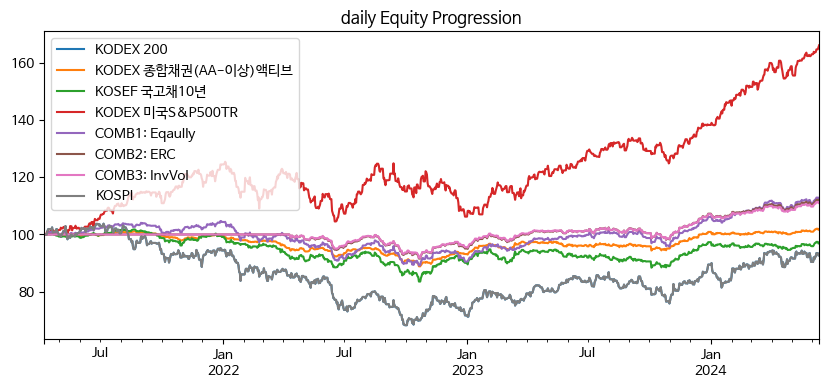

In [134]:
_ = bm.run(figsize=(10,4), freq='D')

In [135]:
bm.get_stats(sort_by='monthly_sharpe')

,KODEX 미국S&P500TR,COMB2: ERC,COMB3: InvVol,COMB1: Eqaully,KODEX 종합채권(AA-이상)액티브,KODEX 200,KOSPI,KOSEF 국고채10년
start,2021-04-08 00:00:00,2021-04-08 00:00:00,2021-04-08 00:00:00,2021-04-08 00:00:00,2021-04-08 00:00:00,2021-04-08 00:00:00,2021-04-08 00:00:00,2021-04-08 00:00:00
end,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00
total_return,0.662483,0.121062,0.112678,0.128243,0.018382,-0.071764,-0.0728,-0.029507
cagr,0.173573,0.036638,0.03419,0.038724,0.005752,-0.023176,-0.023519,-0.009386
calmar,1.041504,0.434416,0.418157,0.261051,0.047539,-0.067612,-0.068748,-0.052352
max_drawdown,-0.166656,-0.084338,-0.081764,-0.148338,-0.120994,-0.342772,-0.342102,-0.179291
avg_drawdown,-0.012782,-0.008997,-0.009467,-0.012904,-0.016232,-0.085841,-0.085707,-0.027775
avg_drawdown_days,16.15,22.0625,24.655172,38.214286,125.888889,229.0,229.0,142.75
daily_vol,0.145413,0.048306,0.046252,0.074863,0.03972,0.167376,0.166854,0.073907
daily_sharpe,1.200943,0.78751,0.768012,0.557501,0.167806,-0.059998,-0.062865,-0.09383


### compare 2

In [136]:
weights = [0.2, 0.2, 0.3, 0.3]
weights = dict(zip(choice, weights))

bm.build(    
    name = 'COMB4: spec',
    freq = 'Y', select = 'all', weigh = 'specified', 
    weights = weights
)

In [137]:
weights = [0.3, 0.2, 0.3, 0.2]
weights = dict(zip(choice, weights))

bm.build(    
    name = 'COMB5: spec',
    freq = 'Y', select = 'all', weigh = 'specified', 
    weights = weights
)

In [138]:
bm.portfolios

0) KODEX 200
1) KODEX 종합채권(AA-이상)액티브
2) KOSEF 국고채10년
3) KODEX 미국S&P500TR
4) COMB1: Eqaully
5) COMB2: ERC
6) COMB3: InvVol
7) KOSPI
8) COMB4: spec
9) COMB5: spec

In [139]:
_ = bm.run([4,5,6,7,8,9], plot=False)
bm.get_stats(sort_by='monthly_sharpe')

Backtesting 6 strategies: COMB1: Eqaully, COMB2: ERC, ... , COMB5: spec


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 16.25it/s]


Returning stats


,COMB2: ERC,COMB3: InvVol,COMB4: spec,COMB1: Eqaully,COMB5: spec,KOSPI
start,2021-04-08 00:00:00,2021-04-08 00:00:00,2021-04-08 00:00:00,2021-04-08 00:00:00,2021-04-08 00:00:00,2021-04-08 00:00:00
end,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00
total_return,0.121062,0.112678,0.159665,0.128243,0.092114,-0.0728
cagr,0.036638,0.03419,0.047747,0.038724,0.028133,-0.023519
calmar,0.434416,0.418157,0.338399,0.261051,0.171118,-0.068748
max_drawdown,-0.084338,-0.081764,-0.141097,-0.148338,-0.164408,-0.342102
avg_drawdown,-0.008997,-0.009467,-0.011447,-0.012904,-0.013153,-0.085707
avg_drawdown_days,22.0625,24.655172,34.16129,38.214286,45.583333,229.0
daily_vol,0.048306,0.046252,0.075128,0.074863,0.077794,0.166854
daily_sharpe,0.78751,0.768012,0.673797,0.557501,0.404358,-0.062865


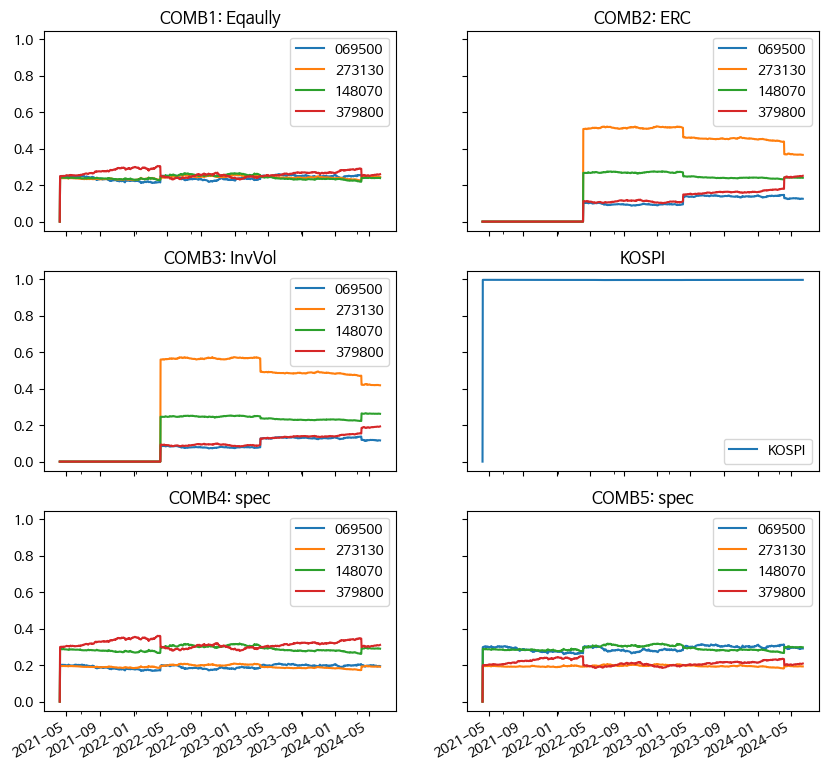

In [140]:
bm.plot_security_weights(figsize=(10,10))

# Scaled

## Data

In [45]:
etfs = ['069500', '273130', '148070', '379800']
{x: etf_names[x] for x in etfs}

{'069500': 'KODEX 200',
 '273130': 'KODEX 종합채권(AA-이상)액티브',
 '148070': 'KOSEF 국고채10년',
 '379800': 'KODEX 미국S&P500TR'}

In [46]:
get_date_range(df_etfs[etfs])

,start date,end date
069500,2002-10-14,2024-06-11
148070,2011-10-20,2024-06-11
273130,2017-06-29,2024-06-11
379800,2021-04-09,2024-06-11


In [47]:
start_date = '2017-06-29'

In [48]:
df_snp = fdr.DataReader('S&P500')
df_snp = df_snp['Adj Close']
df_rate = df_snp/df_snp[0]-1
df_rate

Date
1980-01-02     0.000000
1980-01-03    -0.005106
1980-01-04     0.007186
1980-01-07     0.009928
1980-01-08     0.030163
                ...    
2024-06-11    49.825640
2024-06-12    50.257845
2024-06-13    50.378027
2024-06-14    50.357791
2024-06-17    50.290846
Name: Adj Close, Length: 11209, dtype: float64

In [49]:
df_379800 = df_etfs['379800'].dropna()
df_379800.head()
#df_379800.tail()

Date
2021-04-09    10085.0
2021-04-12    10155.0
2021-04-13    10190.0
2021-04-14    10145.0
2021-04-15    10130.0
Name: 379800, dtype: float64

In [50]:
file = '금융자산운용 - export.csv'
df_info = pd.read_csv(f'{path_data}/{file}')
df_info.iloc[-1]

name            KODEX 미국S&P500TR assumed from S&P500 rate of r...
ticker                                                   379800_R
commission                                                    0.0
data_type                                                      -1
file                                                     379800_R
check1_date                                            2024-06-11
check1_price                                              16770.0
check2_date                                            2021-04-09
check2_price                                              10085.0
Name: 5, dtype: object

In [51]:
data = df_info.iloc[-1]
df_379800r = convert_rate_to_price(data, rate_is_percent=False, df_rate=df_rate)
df_379800r

error: 27.73 %


date
1980-01-02      329.951573
1980-01-03      328.266871
1980-01-04      332.322617
1980-01-07      333.227366
1980-01-08      339.903766
                  ...     
2024-06-11    16770.000000
2024-06-12    16912.606593
2024-06-13    16952.260834
2024-06-14    16945.584007
2024-06-17    16923.495478
Name: 379800_R, Length: 11209, dtype: float64

<Axes: xlabel='Date'>

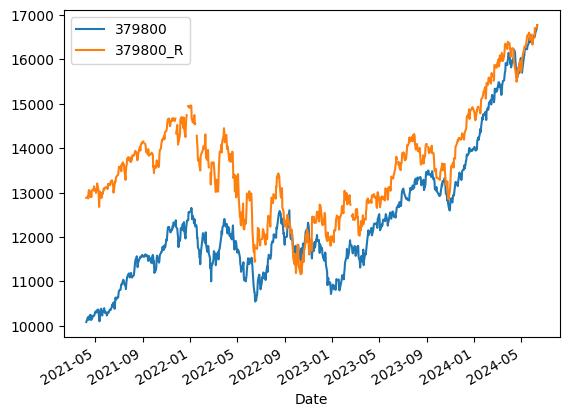

In [52]:
df_379800.to_frame().join(df_379800r).plot()

In [53]:
etfs = ['069500', '273130', '148070']
df = df_etfs[etfs].join(df_379800r).loc[start_date:]
df

,069500,273130,148070,379800_R
Date,,,,
2017-06-29,27193,99855.0,106044.0,7549.014665
2017-06-30,27109,99810.0,105817.0,7560.589054
2017-07-03,27170,99745.0,105613.0,7578.060320
2017-07-04,27002,99655.0,105190.0,NaN
2017-07-05,27105,99620.0,105253.0,7589.073356
...,...,...,...,...
2024-06-04,36390,110605.0,111850.0,16507.998052
2024-06-05,36755,110820.0,112200.0,16703.579031
2024-06-07,37240,111075.0,112610.0,16681.616938


In [54]:
ticker = '379800_R'
etf_names.update({ticker:'KODEX 미국S&P500TR assumed from S&P500 rate of return'})
etfs.append(ticker)

## Backtest

In [55]:
bts = Backtest(df, metrics=metrics, initial_capital=10000000,
               asset_names=etf_names, commissions=None)

backtest period reset: 2017-06-29 ~ 2024-06-11
rate of nan filled forward::
  069500: 0.000
  273130: 0.000
  148070: 0.000
  379800_R: 0.033


In [56]:
name = 'KOSPI'
ticker = '069500'
bts.buy_n_hold(ticker, name=name)

In [57]:
{x:etf_names[x] for x in etfs}

{'069500': 'KODEX 200',
 '273130': 'KODEX 종합채권(AA-이상)액티브',
 '148070': 'KOSEF 국고채10년',
 '379800_R': 'KODEX 미국S&P500TR assumed from S&P500 rate of return'}

In [58]:
name = 'ETF COMB1'
weights = [0.2, 0.2, 0.3, 0.3]
weights = dict(zip(etfs, weights))
bts.build(weights, name, period='Y')

In [59]:
name = 'ETF COMB1 (M)'
weights = [0.2, 0.2, 0.3, 0.3]
weights = dict(zip(etfs, weights))
bts.build(weights, name, period='M', capital_flow=1000000)

In [60]:
name = 'ETF COMB2'
weights = [0.3, 0.2, 0.3, 0.2]
weights = dict(zip(etfs, weights))
bts.build(weights, name, period='Y')

,KOSPI,ETF COMB1,ETF COMB1 (M),ETF COMB2
start,2017-06-28 00:00:00,2017-06-28 00:00:00,2017-06-28 00:00:00,2017-06-28 00:00:00
end,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00
total_return,0.359183,0.450954,0.430813,0.383078
cagr,0.045118,0.054983,0.052865,0.04774
max_drawdown,-0.380162,-0.189178,-0.190569,-0.20192
avg_drawdown,-0.047992,-0.012449,-0.012622,-0.015412
avg_drawdown_days,94.576923,26.809524,27.47561,39.288136
daily_vol,0.184222,0.078006,0.078233,0.077309
daily_sharpe,0.337775,0.743129,0.714828,0.657651
daily_sortino,0.555855,1.165093,1.118762,1.04768


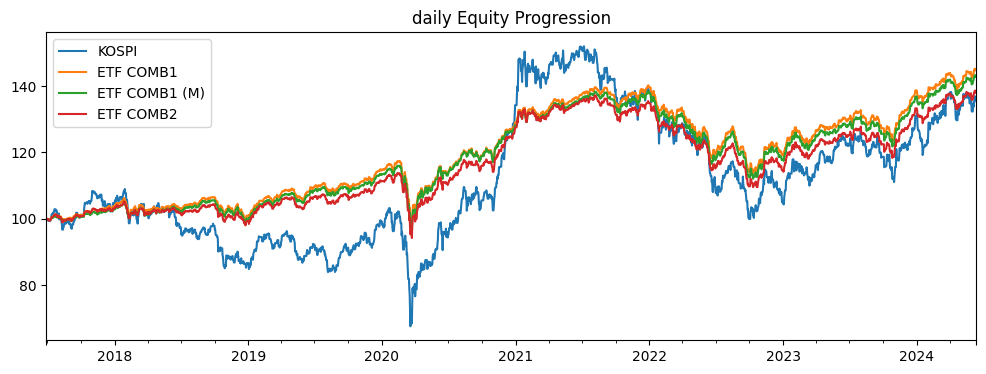

In [61]:
bts.run(figsize=(12,4))

In [82]:
bts.show_weights('ETF COMB1')

KODEX 200                                              0.2
KODEX 종합채권(AA-이상)액티브                                   0.2
KOSEF 국고채10년                                           0.3
KODEX 미국S&P500TR assumed from S&P500 rate of return    0.3
dtype: float64

In [83]:
bts.show_weights('ETF COMB2')

KODEX 200                                              0.3
KODEX 종합채권(AA-이상)액티브                                   0.2
KOSEF 국고채10년                                           0.3
KODEX 미국S&P500TR assumed from S&P500 rate of return    0.2
dtype: float64

# Bayesian

## Portfolios

In [13]:
{x:asset_names[x] for x in df_etfs.columns}

{'273130': 'KODEX 종합채권(AA-이상)액티브',
 '453850': 'ACE 미국30년국채액티브(H)',
 '284430': 'KODEX 200미국채혼합',
 '069500': 'KODEX 200',
 '379800': 'KODEX 미국S&P500TR',
 '411060': 'ACE KRX금현물',
 '305080': 'TIGER 미국채10년선물',
 '304660': 'KODEX 미국30년국채울트라선물(H)',
 '148070': 'KOSEF 국고채10년',
 '261220': 'KODEX WTI원유선물(H)'}

In [14]:
name = 'KOSPI'
tickers = ['069500']
weights = [1]

pfs = list()
kwa = {'name': name, 'weights': dict(zip(tickers, weights))}
pfs.append(kwa)

[asset_names[x] for x in df_etfs[tickers].columns]

['KODEX 200']

In [15]:
{x: asset_names[x] for x in df_tdfs.columns}

{'K55301BU6139': '미래에셋전략배분TDF2035혼합자산자투자신탁종류C-P2e',
 'K55206C95800': '키움키워드림TDF2030증권투자신탁 1[혼합-재간접형]C-P2e(퇴직연금)',
 'K55301BU5453': '미래에셋평생소득TIF혼합자산자투자신탁종류C-P2e',
 'K55301BU5479': '미래에셋전략배분TDF2045혼합자산자투자신탁 종류C-P2e',
 'K55206C96311': '키움키워드림TDF2045증권투자신탁 1[혼합-재간접형]C-P2e(퇴직연금)'}

In [16]:
name = 'TDF COMB'
tickers = ['K55301BU6139', 'K55206C95800']
weights = [0.5, 0.5]
kwa = {'name': name, 'weights': dict(zip(tickers, weights))}
pfs.append(kwa)
[asset_names[x] for x in df_tdfs[tickers].columns]

['미래에셋전략배분TDF2035혼합자산자투자신탁종류C-P2e',
 '키움키워드림TDF2030증권투자신탁 1[혼합-재간접형]C-P2e(퇴직연금)']

In [17]:
tickers = ['K55301BU6139']
name = tickers[0]
weights = [1]
kwa = {'name': name, 'weights': dict(zip(tickers, weights))}
pfs.append(kwa)
[asset_names[x] for x in df_tdfs[tickers].columns]

['미래에셋전략배분TDF2035혼합자산자투자신탁종류C-P2e']

In [18]:
tickers = ['K55206C95800']
name = tickers[0]
weights = [1]
kwa = {'name': name, 'weights': dict(zip(tickers, weights))}
pfs.append(kwa)
[asset_names[x] for x in df_tdfs[tickers].columns]

['키움키워드림TDF2030증권투자신탁 1[혼합-재간접형]C-P2e(퇴직연금)']

## Backtest

In [19]:
df = df_etfs.join(df_tdfs, how='outer')

bts = Backtest(df, metrics=metrics, initial_capital=10000000,
               asset_names=etf_names, commissions=None)

In [20]:
bts.build_batch(*pfs, freq='Y', fill_na=False, reset_portfolios=True)

period reset: 2002-10-14 ~ 2024-06-11
ratio of nan dropped::
  069500: 0.153
period reset: 2018-07-26 ~ 2024-06-13
ratio of nan dropped::
  K55301BU6139: 0.000
  K55206C95800: 0.478
period reset: 2017-09-20 ~ 2024-06-16
ratio of nan dropped::
  K55301BU6139: 0.000
period reset: 2018-07-26 ~ 2024-06-13
ratio of nan dropped::
  K55206C95800: 0.478


,KOSPI,TDF COMB,K55301BU6139,K55206C95800
start,2018-07-25 00:00:00,2018-07-25 00:00:00,2018-07-25 00:00:00,2018-07-25 00:00:00
end,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00,2024-06-11 00:00:00
total_return,0.416803,0.419821,0.501756,0.346793
cagr,0.061033,0.061417,0.071592,0.051929
max_drawdown,-0.346464,-0.215628,-0.215087,-0.219971
avg_drawdown,-0.052969,-0.016192,-0.014093,-0.017237
avg_drawdown_days,82.2,34.333333,27.171429,34.690909
daily_vol,0.193239,0.070285,0.094036,0.090421
daily_sharpe,0.410894,0.905076,0.801393,0.619546
daily_sortino,0.684742,1.364063,1.209366,0.958091


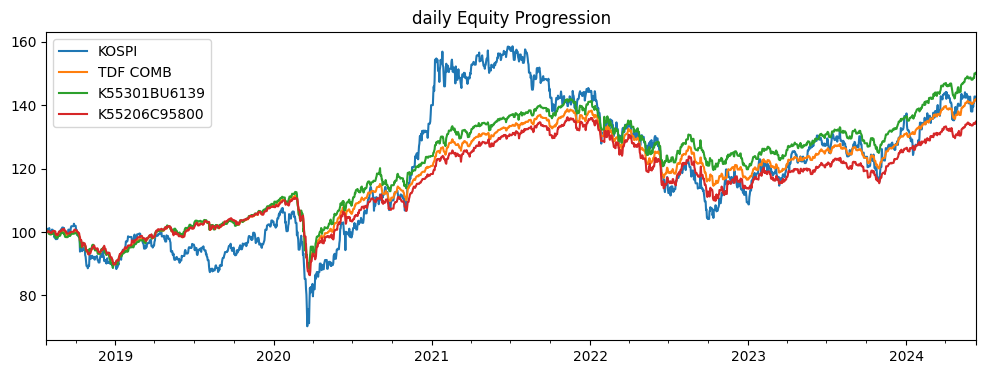

In [21]:
bts.run(figsize=(12,4))

In [22]:
df_bts = bts.get_historical()
df_bts.head()

,KOSPI,TDF COMB,K55301BU6139,K55206C95800
2002-10-14,100.000000,NaN,NaN,NaN
2002-10-15,102.469152,NaN,NaN,NaN
2002-10-16,102.912827,NaN,NaN,NaN
2002-10-17,104.359596,NaN,NaN,NaN
2002-10-18,108.834933,NaN,NaN,NaN


## Estimate

In [23]:
df = df_bts[['KOSPI', 'TDF COMB']]
ae = AssetEvaluator(df)

TDF COMB: 240


In [24]:
ae.summary(freq='yearly')

,KOSPI,TDF COMB
years,21.2,5.7
cagr,0.09689,0.063628
yearly_mean,0.114486,0.068969
yearly_vol,0.222652,0.118083
yearly_sharpe,0.514193,0.584076


In [26]:
ae.bayesian_sample(freq='yearly')

Sampling 4 chains, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:08

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


In [27]:
var_names = ['_mean', '_vol']
ae.bayesian_summary(var_names)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
yearly_mean[KOSPI],0.110,0.003,0.104,0.116,0.0,0.0,4199.0,3146.0,1.0
yearly_mean[TDF COMB],0.068,0.003,0.062,0.075,0.0,0.0,4644.0,3114.0,1.0
yearly_vol[KOSPI],0.212,0.003,0.206,0.218,0.0,0.0,2944.0,3094.0,1.0
yearly_vol[TDF COMB],0.114,0.003,0.109,0.119,0.0,0.0,3889.0,2890.0,1.0


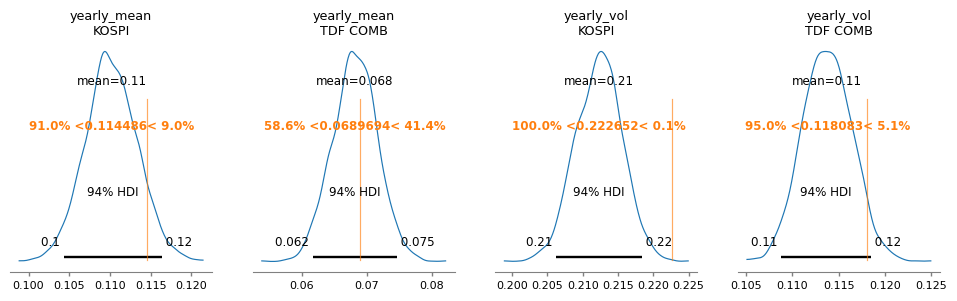

In [29]:
ae.bayesian_plot(var_names, figsize=(12,3), textsize=8)

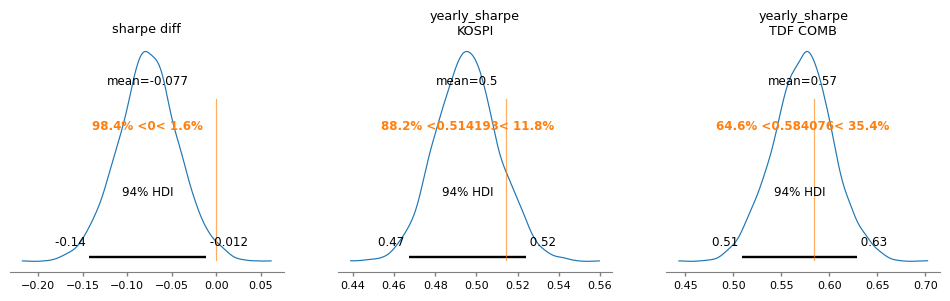

In [30]:
var_names = 'sharpe'
ae.bayesian_plot(var_names, figsize=(12,3), textsize=8)

Sampling 4 chains, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:05

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


period reset: 2018-07-26 ~ 2024-06-11
ratio of nan filled forward::
  KOSPI: 0.000
  TDF COMB: 0.001


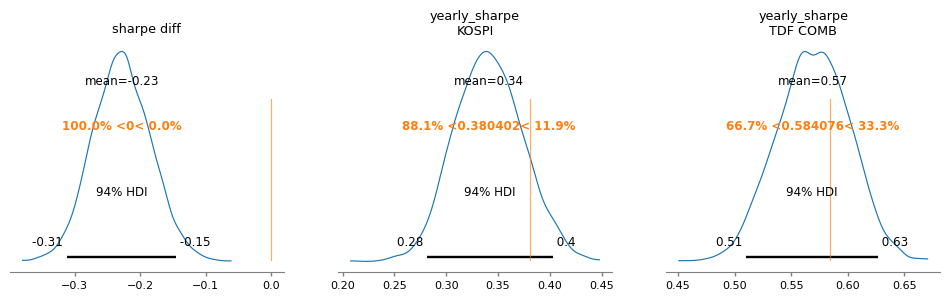

In [31]:
ae.bayesian_sample(freq='yearly', align_period=True)
ae.bayesian_plot(var_names, figsize=(12,3), textsize=8)

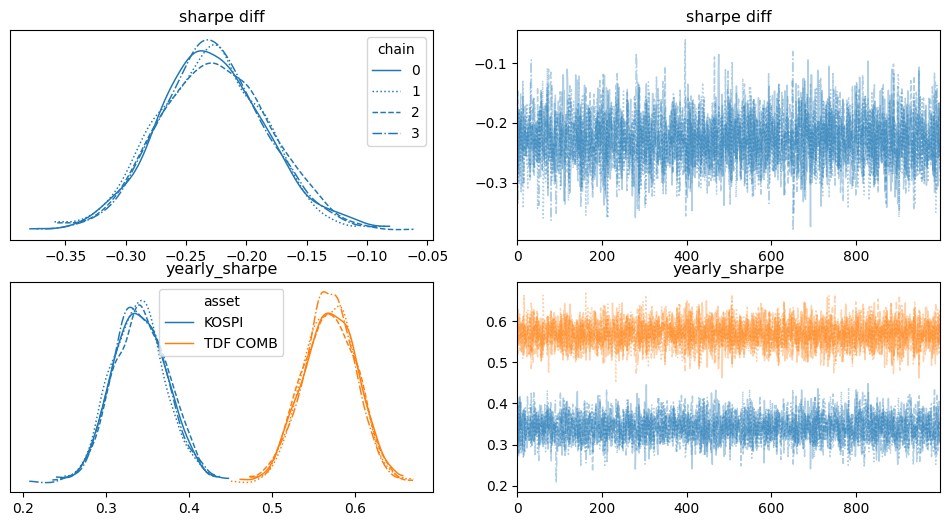

In [32]:
_ = ae.plot_trace(var_names=var_names, legend=True)

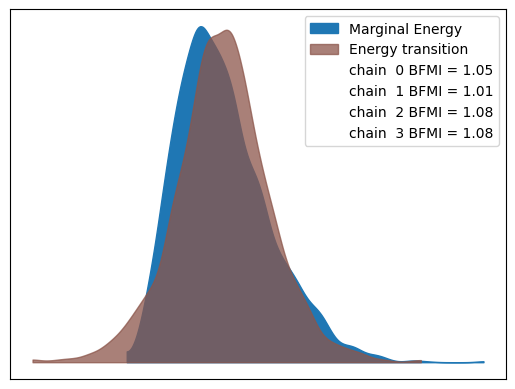

In [33]:
_ = ae.plot_energy()

### Annulize Test

Sampling 4 chains, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:10

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


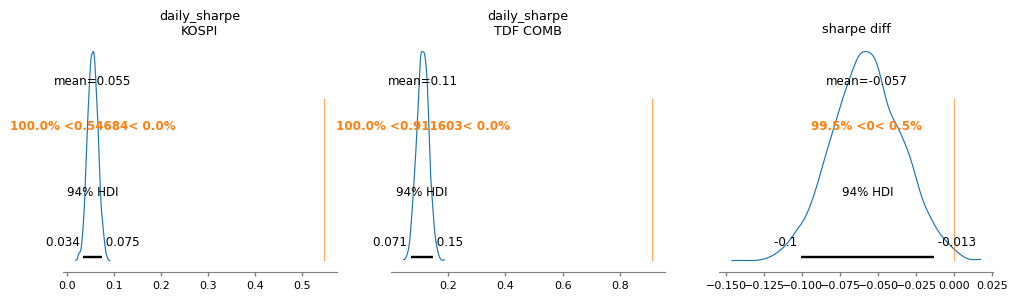

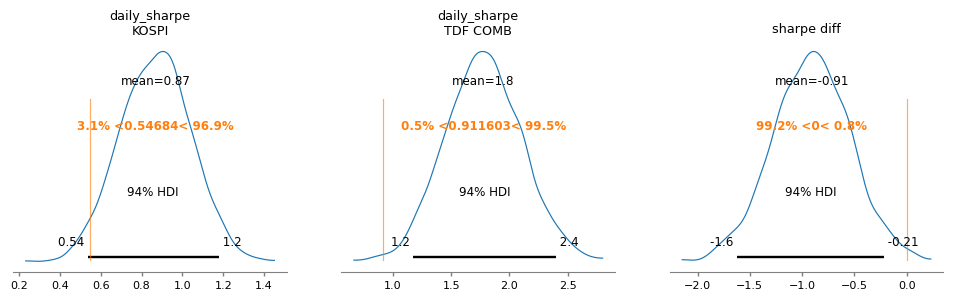

In [34]:
freq='daily'
annualize = True
for debug_annualize in [True, False]:
    ae.bayesian_sample(freq=freq, annualize=annualize, debug_annualize=debug_annualize)
    ae.bayesian_plot('sharpe', figsize=(12,3), textsize=8)

Sampling 4 chains, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:15

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


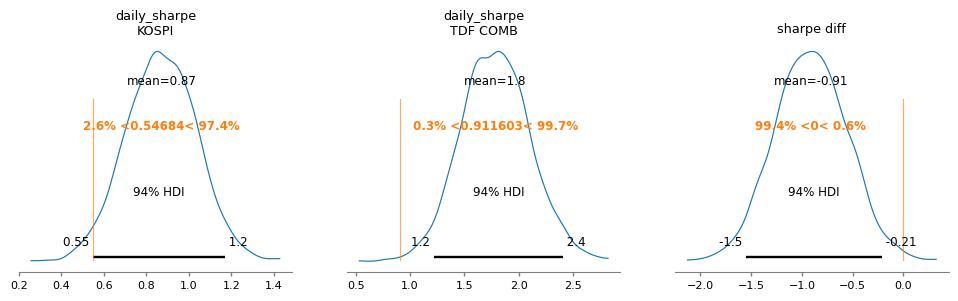

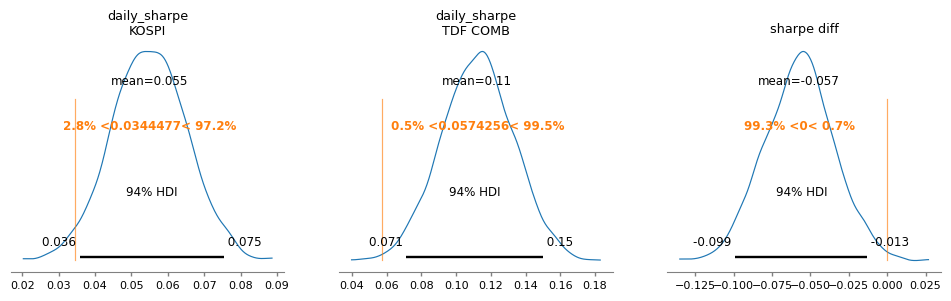

In [261]:
freq='daily'
for annualize in [True, False]:
    ae.bayesian_sample(freq=freq, annualize=annualize)
    ae.bayesian_plot('sharpe', figsize=(12,3), textsize=8)

Sampling 4 chains, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:18

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


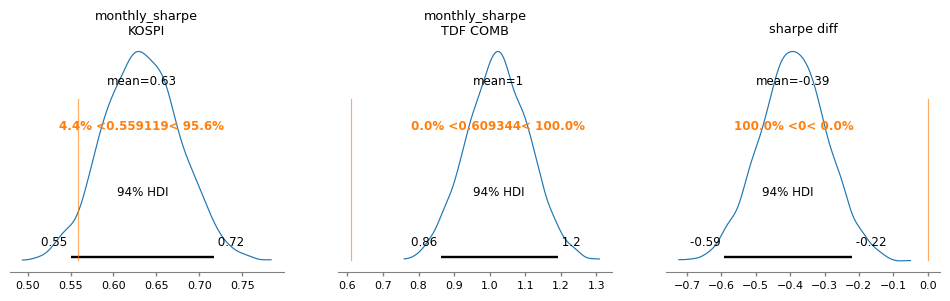

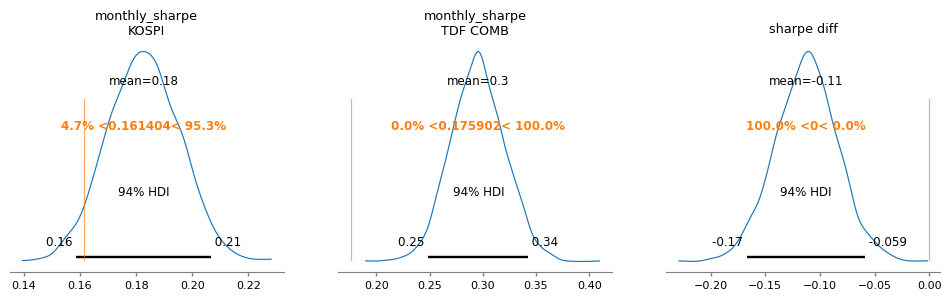

In [262]:
freq='monthly'
for annualize in [True, False]:
    ae.bayesian_sample(freq=freq, annualize=annualize)
    ae.bayesian_plot('sharpe', figsize=(12,3), textsize=8)

Sampling 4 chains, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:09

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


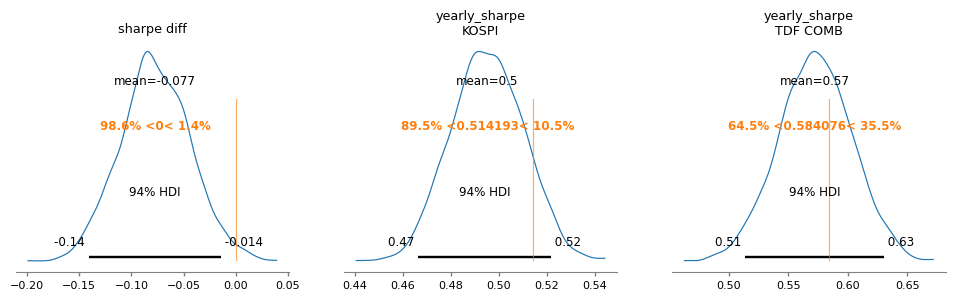

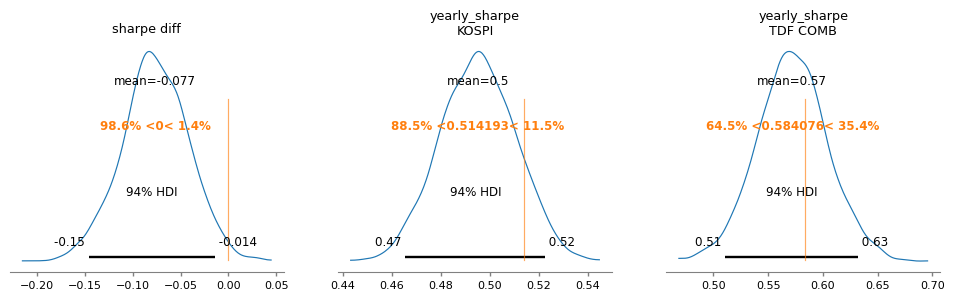

In [263]:
freq='yearly'
for annualize in [True, False]:
    ae.bayesian_sample(freq=freq, annualize=annualize)
    ae.bayesian_plot('sharpe', figsize=(12,3), textsize=8)